In [1]:
import matplotlib.pyplot as plt
import numpy as np

import bemcs

%config InlineBackend.figure_format = "retina"

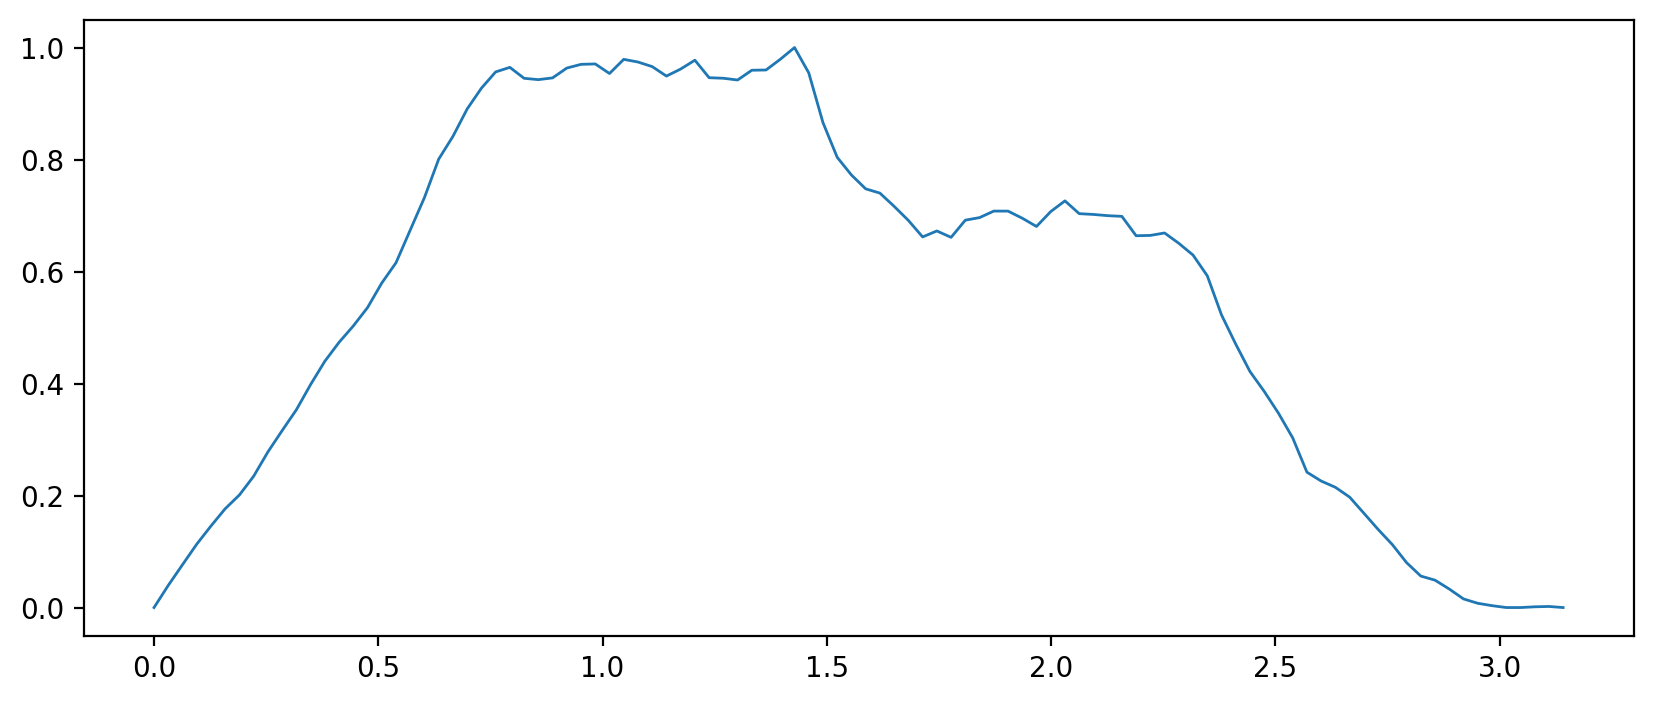

In [7]:
def fractal_noise(num_points, lacunarity=2.0, exponent=-1.0, octaves=6):
    terrain = np.zeros(num_points)
    frequency = 1.0
    amplitude = 1.0
    num_points // frequency

    for _ in range(octaves):
        terrain += amplitude * np.interp(
            np.linspace(0, num_points, num_points, endpoint=False),
            np.linspace(0, num_points, int(num_points // frequency), endpoint=False),
            np.random.normal(size=int(num_points // frequency)),
        )
        frequency *= lacunarity
        amplitude *= exponent

    return terrain


num_points = 100
topo = fractal_noise(num_points, lacunarity=2.0, exponent=-1.0, octaves=6)


# Applying a rolling mean to smooth the terrain and a sinusoidal taper
x = np.linspace(0, np.pi, num_points)
topo = np.convolve(topo, np.ones(100) / 10, mode="same")
topo -= np.min(topo)
topo = topo * np.sin(x)
topo /= np.max(topo)

plt.figure(figsize=(10, 4))
plt.plot(x, topo, linewidth=1.0)
plt.show()

In [3]:
def get_gravity_particular_solution(x, y, g, rho, material_lambda, material_mu):
    """
    Compute the particular solution for the gravity effect on a material.

    This function calculates the displacement fields (ux, uy) and the stress components (sxx, syy, sxy)
    under the influence of gravity for a given material based on the equations provided by Pape and Banerjee (1987).

    Parameters:
    x (ndarray): Array of x-coordinates.
    y (ndarray): Array of y-coordinates.
    g (float): Gravitational acceleration.
    rho (float): Density of the material.
    material_lambda (float): First Lamé parameter of the material.
    material_mu (float): Second Lamé parameter (shear modulus) of the material.

    Returns:
    tuple: Tuple containing:
        ux (ndarray): Displacement in the x-direction.
        uy (ndarray): Displacement in the y-direction.
        sxx (ndarray): xx stress component (zero in this case).
        syy (ndarray): yy stress component.
        sxy (ndarray): xy stress component (zero in this case).
    """
    ux = (
        -material_lambda
        * rho
        * g
        / (4 * material_mu * (material_lambda + material_mu))
        * x
        * y
    )  # Pape and Banerjee (1987) equation (6a)
    uy = (
        (rho * g)
        / (8 * material_mu * (material_lambda + material_mu))
        * (material_lambda * x**2 + (material_lambda + 2 * material_mu) * y**2)
    )  # Pape and Banerjee (1987) equation (6b)
    sxx = np.zeros_like(x)  # Pape and Banerjee (1987) equation (6c)
    syy = rho * g * y  # Pape and Banerjee (1987) equation (6d)
    sxy = np.zeros_like(x)  # Pape and Banerjee (1987) equation (6e)
    return ux, uy, sxx, syy, sxy


alpha = 7e-8  # scalar preconditioner for traction terms
material_mu = 3e10
material_lambda = 3e10
nu = 0.25
rho = 2700
g = 9.81
nels = 20
npts = 100
L = 1e4

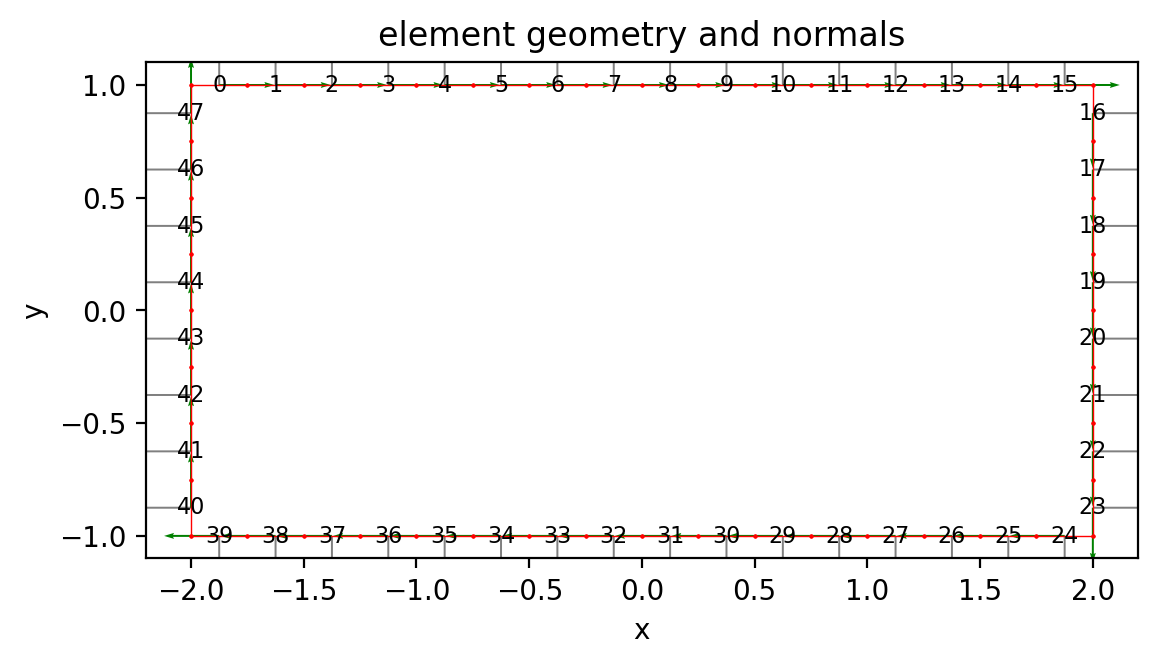

In [4]:
# Create a box
L = 2.0
H = L * 0.5
ngrid = 4
corners = np.array([[-L, H], [L, H], [L, -H], [-L, -H], [-L, H]])

# Create arrays of the x and y coordinates of the corners
x, z = [], []
for i in range(4):
    lsegment = np.sqrt(
        (corners[i, 0] - corners[(i + 1), 0]) ** 2
        + (corners[i, 1] - corners[(i + 1), 1]) ** 2
    )
    xi = np.linspace(
        corners[i][0],
        corners[(i + 1) % 4][0],
        num=round(lsegment * ngrid / H),
        endpoint=False,
    )
    zi = np.linspace(
        corners[i][1],
        corners[(i + 1) % 4][1],
        num=round(lsegment * ngrid / H),
        endpoint=False,
    )
    x.append(xi)
    z.append(zi)
x.append(corners[0, 0])
z.append(corners[0, 1])
x = np.hstack(x)
z = np.hstack(z)

x1_box = x[0:-1]
x2_box = x[1:]
y1_box = z[0:-1]
y2_box = z[1:]

els = bemcs.initialize_els()
els.x1 = x1_box
els.y1 = y1_box
els.x2 = x2_box
els.y2 = y2_box


bemcs.standardize_els_geometry(els, reorder=False)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)

# Modify HRF example?
- `experiment_hrf_strainenergy_boundary.ipynb`

```python
# Common indexing
idx = getidxdict(els) # Should this return "all" - YES TODO
bcidxU = idx["B"] # Boundaries with *displacement* BCs
bcidxT = [idx["R"] ; idx["T"]; idx["L"]] # Boundaries with *traction* BCs
bcidxall = collect(1:1:els.endidx) # All boundaries

# Gravity square problem with quadratic elements
T_pU_qall, _ = PUTQ(slip2dispstress, els, bcidxU, bcidxall, mu, nu)
_, H_pT_qall = PUTQ(slip2dispstress, els, bcidxT, bcidxall, mu, nu)

TH = [T_pU_qall ; alpha .* H_pT_qall] # Assemble combined linear operator

# Particular solution and effective boundary conditions
xnodes = transpose(els.xnodes[idx["B"], :])[:]
ynodes = transpose(els.ynodes[idx["B"], :])[:]
UB, _ = gravityparticularfunctions(xnodes, ynodes, g, rho, lambda, mu)    
bcs = zeros(6 * els.endidx)
bcs[1:2:6*nels] = UB[:, 1] # Bottom boundary (x-component)
bcs[2:2:6*nels] = UB[:, 2] # Bottom boundary (y-component)
bcs *= -1 # This is neccesary for the right answer and is consistent with derivation

# BEM solve to get particular solution
Ueffparticular = inv(TH) * bcs
```

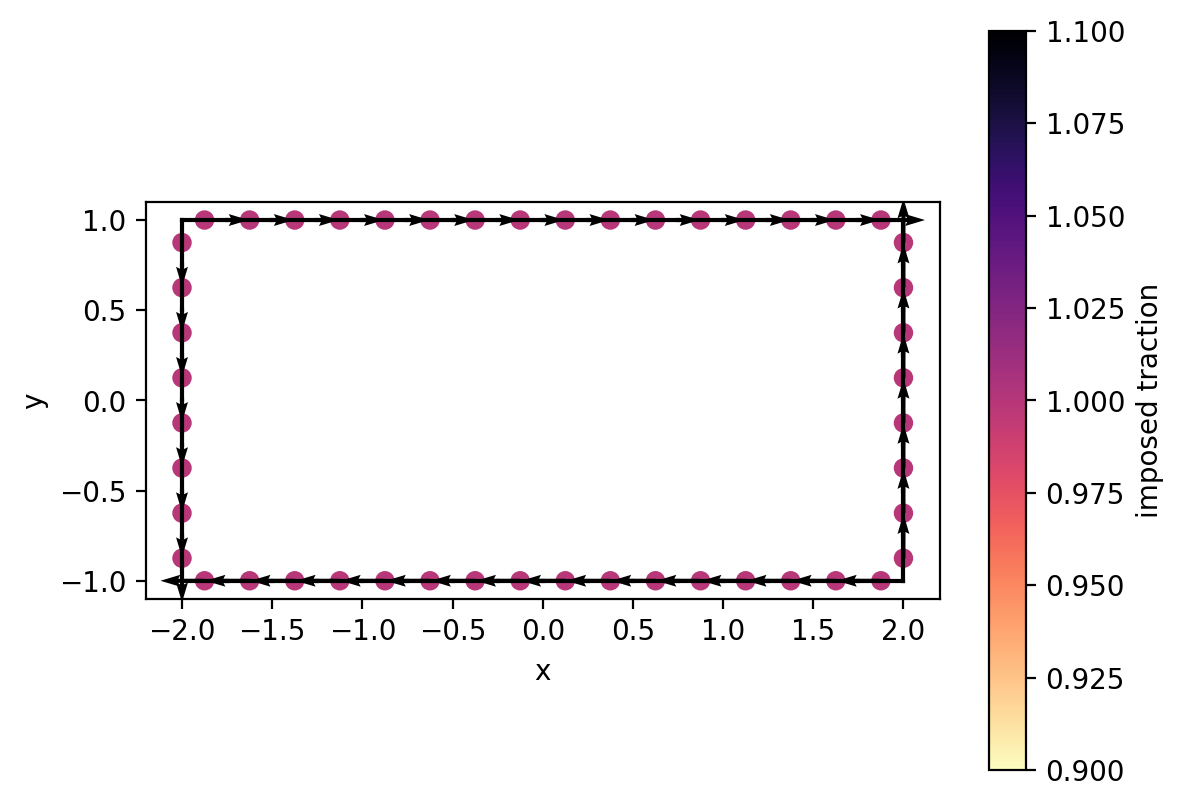

In [6]:
# Global stress tensor
sigma_xx = 0
sigma_yy = -sigma_xx
sigma_xy = 1

traction_vector_x = (
    sigma_xx * els.x_normals[0 : len(x1_box)]
    + sigma_xy * els.y_normals[0 : len(x1_box)]
)
traction_vector_y = (
    sigma_xy * els.x_normals[0 : len(x1_box)]
    + sigma_yy * els.y_normals[0 : len(x1_box)]
)

for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-")

plt.scatter(
    els.x_centers,
    els.y_centers,
    c=np.sqrt(traction_vector_x**2 + traction_vector_y**2),
    marker="o",
    cmap="magma_r",
)
plt.colorbar(label="imposed traction")
plt.quiver(
    els.x_centers, els.y_centers, traction_vector_x, traction_vector_y, width=0.005
)
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()